In [1]:
import pandas as pd
import numpy as np

# 1. Creating the dataset:

In [2]:
# Number of observations
n = 20000

# Generatind random values for each columns:
# 'age': values between 18 and 65
ages = np.random.randint(18, 66, size = n).astype(float) # We convert to float and then introduce NaN

# 'income': values between 30000 and 150000
incomes = np.random.randint(30000, 150001, size = n).astype(float) # We convert to float and then introduce NaN

# 'gender': 'Male' or 'Female'
# We force the type to object to allow NaN
genders = np.random.choice(['Male', 'Female'], size = n, p = [0.5, 0.5]).astype(object)

# 'target': 0 or 1

targets = []
for i in range(n):
    # target = 1 if age > 35 and income > 60000, etc.
    if ages[i] > 35 and incomes[i] > 60000:
        targets.append(1)
    else:
        targets.append(0)

# Introduce missing values ​​randomly:
# For example, 13.7% missing in 'age'
missing_rate_age = 0.137
mask_age = np.random.rand(n) < missing_rate_age
ages[mask_age] = np.nan

# 3.87% missing in 'income'
missing_rate_income = 0.0387
mask_income = np.random.rand(n) < missing_rate_income
incomes[mask_income] = np.nan

# 2.3% missing in 'gender'
missing_rate_gender = 0.023
mask_gender = np.random.rand(n) < missing_rate_gender
genders[mask_gender] = np.nan

# Creating the dictionary with these data
data = {
    'age': ages,
    'income': incomes,
    'gender': genders,
    'target': targets
}

# 2. Create the DataFrame


In [3]:
df = pd.DataFrame(data)

In [4]:
# Verify the number of NaN values per column:
print("NaN values per column:")
print(df.isnull().sum())

NaN values per column:
age       2732
income     709
gender     479
target       0
dtype: int64


In [5]:
# First rows y and the overall of observations
print(df.head())
print("Number of observations:", df.shape[0])

    age    income  gender  target
0  21.0  102804.0  Female       0
1   NaN  118777.0  Female       1
2  48.0   89162.0  Female       1
3  26.0   81203.0  Female       0
4  37.0   39550.0  Female       0
Number of observations: 20000


In [6]:
df.head()

,age,income,gender,target
0,21.0,102804.0,Female,0
1,NaN,118777.0,Female,1
2,48.0,89162.0,Female,1
3,26.0,81203.0,Female,0
4,37.0,39550.0,Female,0


In [7]:
df.describe()

,age,income,target
count,17268.000000,19291.000000,20000.000000
mean,41.560227,89973.976103,0.474350
std,13.828836,34690.418192,0.499354
min,18.000000,30009.000000,0.000000
25%,30.000000,59901.000000,0.000000
50%,42.000000,90100.000000,0.000000
75%,54.000000,119904.000000,1.000000
max,65.000000,149997.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     17268 non-null  float64
 1   income  19291 non-null  float64
 2   gender  19521 non-null  object 
 3   target  20000 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 625.1+ KB


In [9]:
df.isnull().sum()

,0
age,2732
income,709
gender,479
target,0


# 3. Separate the predictor variables (X) and the target variable (y)

In [10]:
X = df.drop('target', axis=1)
y = df['target']

In [11]:
# Numeric and categorical values (list)
numeric_features = ['age', 'income']
categorical_features = ['gender']

# 4. Pipelines

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [13]:
# Pipeline for numeric features: impute missing values ​​with mean and then scale
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

In [15]:
# Pipeline for categorical features: impute with mode and apply One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [19]:
# Build the full pipeline: preprocessing + classification model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', class_weight = 'balanced', max_iter = 1000, random_state = 42))
])

# 5. Training and testing sets

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Define the hyperparameter grid
param_grid = {
    # Adjust the imputation strategy in numerical variables: "mean" or "median"
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    # Adjust parameter C in logistic regression (controls regularization)
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy')

In [25]:
# Entrenar el GridSearch
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'income']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             scoring='accuracy')

# 6. Print the best parameters and the best score in cross validation

In [26]:
print("Best parameters:", grid_search.best_params_)
print("Best accuracy in cross validation:", grid_search.best_score_)

Best parameters: {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}
Best accuracy in cross validation: 0.81525


In [27]:
# Evaluate the fitted model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Accuracy in testing with the best model: {test_accuracy * 100:.2f}%")

Accuracy in testing with the best model: 81.45%


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 7. Results

In [29]:
# Suppose you have already trained your pipeline and X_test, y_test are your test data:
y_pred = best_model.predict(X_test)

In [30]:
# Calculate and display the global accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

Accuracy: 81.45%



In [31]:
# View all metrics with classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2103
           1       0.80      0.82      0.81      1897

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.82      0.81      0.81      4000



# Confusion Matrix

In [32]:
cm = confusion_matrix(y_test, y_pred)

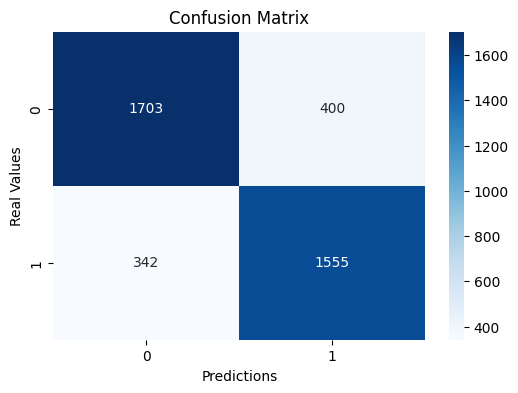

In [33]:
# Visualize the confusion matrix with Seaborn
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.show()

# 8. Evaluate the model

In [34]:
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)
print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing accuracy: {test_accuracy * 100:.2f}%")

Training accuracy: 81.53%
Testing accuracy: 81.45%
